In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from importlib import reload
from scipy import signal
from scipy.integrate import solve_ivp
from scipy.signal import cont2discrete, tf2ss
import math
from _GraphUtils import *
import control as ct
from numba import njit

path = r'params2.csv'
params = pd.read_csv(path)
params = dict(zip(params['Parameter'], params['Value']))

path2 = r'Datasets/WindSpeed_V1.csv'
df = pd.read_csv(path2)  
v = df.iloc[:,0].values + 1
v = np.sqrt(np.flip(v) )*4*1.5

In [2]:
# --- Carregamento de Dados (Fora da Classe para eficiência) ---

def load_lookup_tables():
    # Definição dos eixos conforme seu código original
    angles = np.array([-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95])
    
    # Carregando CSVs uma única vez
    df_cp = pd.read_csv(r'Cp.csv')
    df_cq = pd.read_csv(r'Cq.csv')
    
    # Extraindo eixos e tabelas
    # Assumindo que a coluna 0 é o TSR
    tsr_axis = df_cp.iloc[:, 0].values.astype(np.float64)
    
    # As tabelas de dados (removendo a coluna de TSR para ter apenas os coeficientes)
    # O seu código original fazia id2 + 1, o que sugere que 'angles' mapeia da coluna 1 em diante
    cp_table = df_cp.iloc[:, 1:].values.astype(np.float64)
    cq_table = df_cq.iloc[:, 1:].values.astype(np.float64)
    
    return tsr_axis, angles, cp_table, cq_table

# Carrega globalmente para passar para a classe ou função
try:
    TSR_AXIS, PITCH_AXIS, CP_TABLE, CQ_TABLE = load_lookup_tables()
except FileNotFoundError:
    print("Aviso: Arquivos CSV (Cp.csv, Cq.csv) não encontrados. Usando dados dummy para teste.")
    TSR_AXIS = np.linspace(0, 20, 100)
    PITCH_AXIS = np.linspace(-2, 95, 33)
    CP_TABLE = np.random.rand(100, 33) * 0.5
    CQ_TABLE = np.random.rand(100, 33) * 0.05

# Carrega parametros e vento (código original adaptado)
try:
    params = pd.read_csv(r'params2.csv')
    params = dict(zip(params['Parameter'], params['Value']))
    
    df_wind = pd.read_csv(r'Datasets/WindSpeed_V1.csv')
    v_raw = df_wind.iloc[:,0].values + 1
    # Mantendo a lógica de transformação do vento do usuário
    V_WIND = np.sqrt(np.flip(v_raw)) * 4 * 1.5
except FileNotFoundError:
    print("Aviso: Dados de vento ou params não encontrados. Usando dados dummy.")
    params = {
        'Area': 100, 'B_dt': 1, 'B_r': 1, 'B_g': 1, 'CP_max': 0.45, 'ETA_dt': 0.9, 'ETA_gc': 0.9,
        'J_r': 100, 'J_g': 10, 'K_dt': 1000, 'k_i': 1, 'k_p': 1, 'LAMBDA_opt': 8, 'N_g': 90,
        'OMEGA_n': 1, 'OMEGA_nom': 100, 'OMEGA_var': 1, 'PHI_opt': 0, 'P_r': 1000, 'PI': np.pi,
        'R': 40, 'RHO': 1.225
    }
    V_WIND = np.ones(1000) * 12.0

# --- Funções Otimizadas com Numba ---

@njit(fastmath=True)
def get_coefficient(lambda_val, phi_val, tsr_axis, pitch_axis, data_table):
    """
    Substitui Cp_calc e Cq_calc. Realiza a busca pelo vizinho mais próximo
    de forma extremamente rápida sem ler arquivos.
    """
    # Encontrar índice mais próximo para TSR (Lambda)
    # Assume que tsr_axis é a coluna 0 do dataframe original
    diff1 = np.abs(tsr_axis - lambda_val)
    id1 = np.argmin(diff1)

    # Encontrar índice mais próximo para Pitch (Phi)
    diff2 = np.abs(pitch_axis - phi_val)
    id2 = np.argmin(diff2) 
    
    # Retorna o valor da tabela lookup
    return data_table[id1, id2]

@njit(fastmath=True)
def simulation_core(N_steps, dt, Ad, Bd, X_init, wind_speed, 
                    R, RHO, Area, N_g, ETA_gc, lambda_opt, 
                    tsr_axis, pitch_axis, cp_table, cq_table):
    """
    Executa o loop completo de simulação.
    """
    # Pré-alocação de arrays (Evita np.append)
    X_hist = np.zeros((N_steps, 3))
    U_hist = np.zeros((N_steps, 2))
    
    w_r_hist = np.zeros(N_steps)
    w_g_hist = np.zeros(N_steps)
    tau_r_hist = np.zeros(N_steps)
    tau_g_hist = np.zeros(N_steps)
    P_g_hist = np.zeros(N_steps)
    
    # Estado inicial
    X_curr = X_init.astype(np.float64).flatten() # Garante vetor 1D
    
    for k in range(N_steps):
        # Extrair estados atuais
        w_r = X_curr[0]
        w_g = X_curr[1]
        theta_s = X_curr[2]
        
        v = wind_speed[k]
        
        # --- Cálculo de Torque Rotor (Calculte_τr) ---
        # Evita divisão por zero
        if v < 0.1: 
            lamb = 0.0
        else:
            lamb = w_r * R / v
            
        # Busca Cq na tabela pré-carregada (Phi fixo em 0 por enquanto conforme original)
        C_q = get_coefficient(lamb, 0.0, tsr_axis, pitch_axis, cq_table)
        
        tau_r = RHO * np.pi * (R**3) * C_q * (v**2) / 2.0
        
        # --- Cálculo de Torque Gerador (Calculte_τg - MPPT) ---
        lambda_mppt = lambda_opt # u_k assumido 0 conforme original
        
        # Busca Cp na tabela pré-carregada
        C_p = get_coefficient(lambda_mppt, 0.0, tsr_axis, pitch_axis, cp_table)
        
        K_mppt = RHO * Area * (R**3) * C_p / (2 * (lambda_mppt**3) * N_g)
        tau_g = K_mppt * ((w_g / N_g)**2)
        P_g = ETA_gc * w_g * tau_g
        
        # --- Atualização de Estados (Space State) ---
        # U = [tau_r, tau_g]
        # X_next = Ad * X + Bd * U
        
        # Cálculo manual matricial para velocidade (Ad @ X + Bd @ U)
        # X (3x1), U (2x1)
        
        x_next_0 = (Ad[0,0]*X_curr[0] + Ad[0,1]*X_curr[1] + Ad[0,2]*X_curr[2]) + (Bd[0,0]*tau_r + Bd[0,1]*tau_g)
        x_next_1 = (Ad[1,0]*X_curr[0] + Ad[1,1]*X_curr[1] + Ad[1,2]*X_curr[2]) + (Bd[1,0]*tau_r + Bd[1,1]*tau_g)
        x_next_2 = (Ad[2,0]*X_curr[0] + Ad[2,1]*X_curr[1] + Ad[2,2]*X_curr[2]) + (Bd[2,0]*tau_r + Bd[2,1]*tau_g)
        
        # Atualiza vetor atual
        X_curr[0] = x_next_0
        X_curr[1] = x_next_1
        X_curr[2] = x_next_2
        
        # Salva no histórico
        X_hist[k, 0] = x_next_0
        X_hist[k, 1] = x_next_1
        X_hist[k, 2] = x_next_2
        
        U_hist[k, 0] = tau_r
        U_hist[k, 1] = tau_g
        
        w_r_hist[k] = w_r
        w_g_hist[k] = w_g
        tau_r_hist[k] = tau_r
        tau_g_hist[k] = tau_g
        P_g_hist[k] = P_g

    return X_hist, U_hist, w_r_hist, w_g_hist, tau_r_hist, tau_g_hist, P_g_hist

In [9]:
@njit(fastmath=True)
def simulation_core(N_steps, dt, Ad, Bd, X_init, wind_speed, 
                    R, RHO, Area, N_g, ETA_gc, lambda_opt, 
                    tsr_axis, pitch_axis, cp_table, cq_table):
    """
    Executa o loop completo de simulação.
    """
    # Pré-alocação de arrays (Evita np.append)
    X_hist = np.zeros((N_steps, 3))
    U_hist = np.zeros((N_steps, 2))
    
    w_r_hist = np.zeros(N_steps)
    w_g_hist = np.zeros(N_steps)
    tau_r_hist = np.zeros(N_steps)
    tau_g_hist = np.zeros(N_steps)
    P_g_hist = np.zeros(N_steps)
    
    # Estado inicial
    X_curr = X_init.astype(np.float64).flatten() # Garante vetor 1D
    
    for k in range(N_steps):
        # Extrair estados atuais
        w_r = X_curr[0]
        w_g = X_curr[1]
        theta_s = X_curr[2]
        
        v = wind_speed[k]
        
        # --- Cálculo de Torque Rotor (Calculte_τr) ---
        # Evita divisão por zero
        if v < 0.1: 
            lamb = 0.0
        else:
            lamb = w_r * R / v
            
        # Busca Cq na tabela pré-carregada (Phi fixo em 0 por enquanto conforme original)
        C_q = get_coefficient(lamb, 0.0, tsr_axis, pitch_axis, cq_table)
        
        tau_r = RHO * np.pi * (R**3) * C_q * (v**2) / 2.0
        
        # --- Cálculo de Torque Gerador (Calculte_τg - MPPT) ---
        lambda_mppt = lambda_opt # u_k assumido 0 conforme original
        
        # Busca Cp na tabela pré-carregada
        C_p = get_coefficient(lambda_mppt, 0.0, tsr_axis, pitch_axis, cp_table)
        
        K_mppt = RHO * Area * (R**3) * C_p / (2 * (lambda_mppt**3) * N_g)
        tau_g = K_mppt * ((w_g / N_g)**2)
        P_g = ETA_gc * w_g * tau_g
        
        # --- Atualização de Estados (Space State) ---
        # U = [tau_r, tau_g]
        # X_next = Ad * X + Bd * U
        
        # Cálculo manual matricial para velocidade (Ad @ X + Bd @ U)
        # X (3x1), U (2x1)
        
        x_next_0 = (Ad[0,0]*X_curr[0] + Ad[0,1]*X_curr[1] + Ad[0,2]*X_curr[2]) + (Bd[0,0]*tau_r + Bd[0,1]*tau_g)
        x_next_1 = (Ad[1,0]*X_curr[0] + Ad[1,1]*X_curr[1] + Ad[1,2]*X_curr[2]) + (Bd[1,0]*tau_r + Bd[1,1]*tau_g)
        x_next_2 = (Ad[2,0]*X_curr[0] + Ad[2,1]*X_curr[1] + Ad[2,2]*X_curr[2]) + (Bd[2,0]*tau_r + Bd[2,1]*tau_g)
        
        # Atualiza vetor atual
        X_curr[0] = x_next_0
        X_curr[1] = x_next_1
        X_curr[2] = x_next_2
        
        # Salva no histórico
        X_hist[k, 0] = x_next_0
        X_hist[k, 1] = x_next_1
        X_hist[k, 2] = x_next_2
        
        U_hist[k, 0] = tau_r
        U_hist[k, 1] = tau_g
        
        w_r_hist[k] = w_r
        w_g_hist[k] = w_g
        tau_r_hist[k] = tau_r
        tau_g_hist[k] = tau_g
        P_g_hist[k] = P_g

    return X_hist, U_hist, w_r_hist, w_g_hist, tau_r_hist, tau_g_hist, P_g_hist

In [4]:
class HAWT:
    def __init__(self, wind_profile, **params):
        # Mapeia parametros do dicionário para self
        for k, v in params.items():
            setattr(self, k, v)
            
        self.T_s = 0.01 # Definindo um Ts fixo, se não vier do params
        if 'T_s' in params: self.T_s = params['T_s']

        self.wind_profile = wind_profile
        
        # Condições Iniciais
        self.X_init = np.array([0.1, 0.1*self.N_g, 0])
        
        # Criação das matrizes do sistema (Executado em Python normal - apenas uma vez)
        self._build_matrices()

    def _build_matrices(self):
        A11 = -(self.B_dt+self.B_r)/self.J_r
        A12 = self.B_dt/(self.N_g*self.J_r)
        A13 = -self.K_dt/self.J_r
        A21 = (self.B_dt*self.ETA_dt)/(self.N_g*self.J_g)
        A22 = -(((self.B_dt*self.ETA_dt)/(self.N_g**2))+self.B_g)*(1/self.J_g)
        A23 = (self.K_dt*self.ETA_dt)/(self.N_g*self.J_g)
        A32 = -1/self.N_g
        B11 = 1/self.J_r
        B22 = -1/self.J_g
        
        A = np.array([[A11, A12, A13],
                      [A21, A22, A23],
                      [ 1, A32,   0]])
        
        B = np.array([[B11,   0],
                      [  0, B22],
                      [  0,   0]])

        n_states = A.shape[0]
        n_inputs = B.shape[1]
        C = np.eye(n_states) 
        D = np.zeros((n_states, n_inputs))

        sys_c = ct.ss(A, B, C, D)
        sys_d = ct.c2d(sys_c, self.T_s, method='zoh')
        
        # Salva como contiguous array para o Numba gostar
        self.Ad = np.ascontiguousarray(sys_d.A)
        self.Bd = np.ascontiguousarray(sys_d.B)

    def run(self):
        # Prepara dados
        N = len(self.wind_profile)
        
        # Chama a função compilada (JIT)
        # Na primeira execução ela compila (demora um pouco), nas próximas é instantâneo
        results = simulation_core(
            N, self.T_s, self.Ad, self.Bd, self.X_init, self.wind_profile,
            self.R, self.RHO, self.Area, self.N_g, self.ETA_gc, self.LAMBDA_opt,
            TSR_AXIS, PITCH_AXIS, CP_TABLE, CQ_TABLE
        )
        
        # Desempacota resultados
        self.X_hist, self.U_hist, self.wr_hist, self.wg_hist, self.tr_hist, self.tg_hist, self.Pg_hist = results
        
        print("Simulação concluída.")

Simulação concluída.
Tempo de execução: 0.3390 segundos


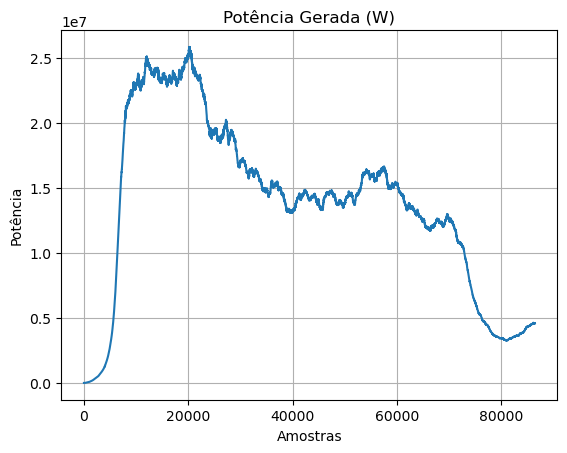

In [10]:
# --- Execução ---

# Instancia
wind_turbine = HAWT(V_WIND, **params)

# Roda simulação
import time
start = time.time()
wind_turbine.run()
end = time.time()
print(f"Tempo de execução: {end - start:.4f} segundos")

# Exemplo de Plot
plt.figure()
plt.plot(wind_turbine.Pg_hist)
plt.title("Potência Gerada (W)")
plt.xlabel("Amostras")
plt.ylabel("Potência")
plt.grid(True)
plt.show()

Iniciando simulação com 86400 passos...
Simulação concluída em 0.6515 segundos.


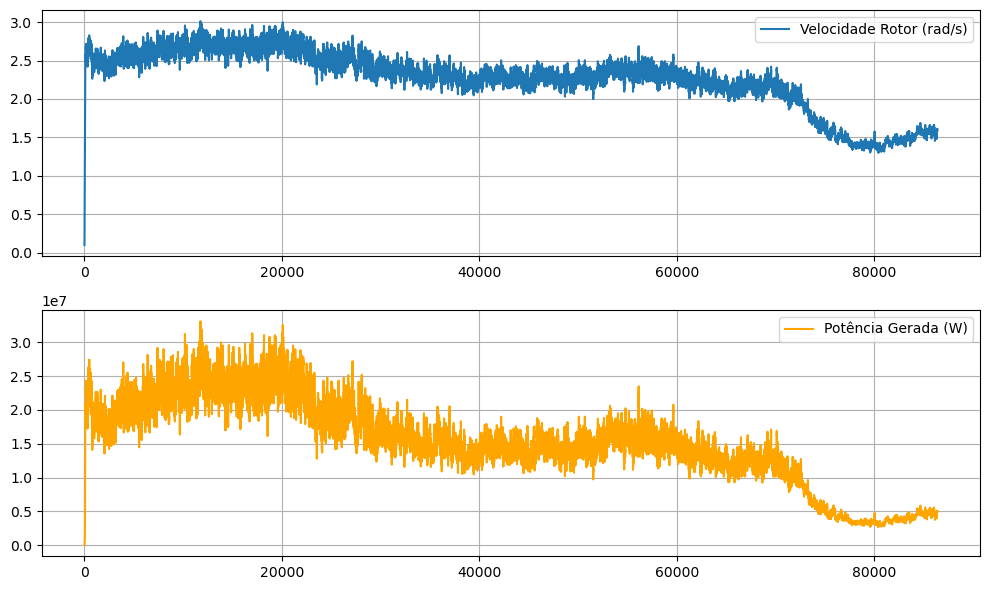

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import control as ct
from numba import njit
import time

# --- 1. Funções Auxiliares Compiladas (Numba) ---

@njit(fastmath=True)
def get_coefficient(lambda_val, phi_val, tsr_axis, pitch_axis, data_table):
    """Substitui Cp_calc e Cq_calc com busca rápida na tabela."""
    # Encontrar índice mais próximo para TSR (Lambda)
    diff1 = np.abs(tsr_axis - lambda_val)
    id1 = np.argmin(diff1)

    # Encontrar índice mais próximo para Pitch (Phi)
    diff2 = np.abs(pitch_axis - phi_val)
    id2 = np.argmin(diff2) 
    
    return data_table[id1, id2]

@njit(fastmath=True)
def simulation_core(N_steps, v_wind, 
                    hawt_Ad, hawt_Bd, hawt_X,
                    gtc_Ad, gtc_Bd, gtc_Cd, gtc_Dd, gtc_X,
                    pac_Ad, pac_Bd, pac_Cd, pac_Dd, pac_X,
                    R, RHO, Area, N_g, PI, P_r, lambda_opt, eta_gc, omega_nom,
                    tsr_axis, pitch_axis, cp_table, cq_table):
    """
    Loop principal de simulação compilado.
    Contém a lógica de todas as classes (HAWT, GTC, PAC, PWC, ADM) fundidas.
    """
    
    # Pré-alocação de históricos (muito mais rápido que np.append)
    w_r_hist = np.zeros(N_steps)
    w_g_hist = np.zeros(N_steps)
    theta_s_hist = np.zeros(N_steps)
    tau_r_hist = np.zeros(N_steps)
    tau_g_hist = np.zeros(N_steps)
    phi_m_hist = np.zeros(N_steps)
    P_g_hist = np.zeros(N_steps)
    
    # Variáveis de estado locais
    x_hawt = hawt_X.flatten().astype(np.float64) # [w_r, w_g, theta_s]
    x_gtc = gtc_X.flatten().astype(np.float64)   # [estado_torque]
    x_pac = pac_X.flatten().astype(np.float64)   # [estado_pitch_1, estado_pitch_2]
    
    for k in range(N_steps):
        v = v_wind[k]
        
        # --- Desempacota Estados Atuais HAWT ---
        w_r = x_hawt[0]
        w_g = x_hawt[1]
        theta_s = x_hawt[2]
        
        # --- PowerController (PWC) ---
        # calculte_τgr
        epsilon = w_g - omega_nom
        
        # Como u_k = 0 no original, lambda = lambda_opt
        # lambda_val = lambda_opt + 0 
        
        # Cp_calc para controle (Pitch fixo em 0 para MPPT)
        C_p = get_coefficient(lambda_opt, 0.0, tsr_axis, pitch_axis, cp_table)
        
        K_opt = RHO * Area * (R**3) * C_p / (2 * (lambda_opt**3) * N_g)
        tau_gr = K_opt * ((w_g / N_g)**2)
        
        phi_ref = 0.0 # Lógica original fixa phi_ref em 0
        
        # --- GeneratorTorqueConverter (GTC) ---
        # Entrada u_gtc = tau_gr
        # Saída y_gtc = C*x + D*u
        # Próximo estado x_gtc = A*x + B*u
        
        u_gtc = tau_gr
        
        # Cálculo Saída GTC (tau_g aplicado)
        # Como x_gtc e u_gtc são escalares/pequenos vetores, fazemos direto
        # y_gtc = (gtc_Cd @ x_gtc + gtc_Dd * u_gtc).item()
        y_gtc = (gtc_Cd[0,0]*x_gtc[0]) + (gtc_Dd[0,0]*u_gtc)
        tau_g_aplicado = y_gtc
        
        P_g = eta_gc * w_g * tau_g_aplicado
        
        # Atualiza estado GTC
        x_gtc_next = (gtc_Ad[0,0]*x_gtc[0]) + (gtc_Bd[0,0]*u_gtc)
        x_gtc[0] = x_gtc_next
        
        # --- PitchAngleController (PAC) ---
        # Entrada u_pac = phi_ref
        u_pac = phi_ref
        
        # Cálculo Saída PAC (phi_m)
        # y_pac = C*x + D*u
        # A matriz C é 1x2, x é 2x1. D é 1x1.
        y_pac = (pac_Cd[0,0]*x_pac[0] + pac_Cd[0,1]*x_pac[1]) + (pac_Dd[0,0]*u_pac)
        phi_m = y_pac
        
        # Atualiza estado PAC (Matricial 2x2)
        # x_next = A*x + B*u
        x_pac_0_next = (pac_Ad[0,0]*x_pac[0] + pac_Ad[0,1]*x_pac[1]) + (pac_Bd[0,0]*u_pac)
        x_pac_1_next = (pac_Ad[1,0]*x_pac[0] + pac_Ad[1,1]*x_pac[1]) + (pac_Bd[1,0]*u_pac)
        x_pac[0] = x_pac_0_next
        x_pac[1] = x_pac_1_next
        
        # --- AerodynamicModel (ADM) ---
        # calculte_τr
        if v < 0.1:
            lamb = 0.0
        else:
            lamb = w_r * R / v
            
        C_q = get_coefficient(lamb, phi_m, tsr_axis, pitch_axis, cq_table)
        tau_r = RHO * PI * (R**3) * C_q * (v**2) / 2.0
        
        # --- HAWT Dynamics (Atualização Final) ---
        # Entradas: u_hawt = [tau_r, tau_g_aplicado]
        # x_next = Ad*x + Bd*u
        
        # Desdobrando cálculo matricial 3x3 para velocidade
        # x_hawt_next = hawt_Ad @ x_hawt + hawt_Bd @ [tau_r, tau_g]
        
        term_Ad_0 = hawt_Ad[0,0]*x_hawt[0] + hawt_Ad[0,1]*x_hawt[1] + hawt_Ad[0,2]*x_hawt[2]
        term_Bd_0 = hawt_Bd[0,0]*tau_r + hawt_Bd[0,1]*tau_g_aplicado
        x_hawt_0_next = term_Ad_0 + term_Bd_0
        
        term_Ad_1 = hawt_Ad[1,0]*x_hawt[0] + hawt_Ad[1,1]*x_hawt[1] + hawt_Ad[1,2]*x_hawt[2]
        term_Bd_1 = hawt_Bd[1,0]*tau_r + hawt_Bd[1,1]*tau_g_aplicado
        x_hawt_1_next = term_Ad_1 + term_Bd_1

        term_Ad_2 = hawt_Ad[2,0]*x_hawt[0] + hawt_Ad[2,1]*x_hawt[1] + hawt_Ad[2,2]*x_hawt[2]
        term_Bd_2 = hawt_Bd[2,0]*tau_r + hawt_Bd[2,1]*tau_g_aplicado
        x_hawt_2_next = term_Ad_2 + term_Bd_2
        
        # Atualiza vetor estado HAWT
        x_hawt[0] = x_hawt_0_next
        x_hawt[1] = x_hawt_1_next
        x_hawt[2] = x_hawt_2_next
        
        # --- Salvar Histórico ---
        w_r_hist[k] = w_r
        w_g_hist[k] = w_g
        theta_s_hist[k] = theta_s
        tau_r_hist[k] = tau_r
        tau_g_hist[k] = tau_g_aplicado
        phi_m_hist[k] = phi_m
        P_g_hist[k] = P_g

    return w_r_hist, w_g_hist, theta_s_hist, tau_r_hist, tau_g_hist, phi_m_hist, P_g_hist

# --- 2. Preparação de Dados (Python Puro - Executado 1x) ---

def load_data_and_params():
    # Carrega Parametros
    try:
        params_df = pd.read_csv(r'params2.csv')
        params = dict(zip(params_df['Parameter'], params_df['Value']))
    except:
        # Fallback se não tiver arquivo
        print("Aviso: params2.csv não encontrado. Usando defaults.")
        params = {'Area': 100, 'B_dt': 1, 'B_r': 1, 'B_g': 1, 'CP_max': 0.45, 
                  'ETA_dt': 0.9, 'ETA_gc': 0.9, 'J_r': 100, 'J_g': 10, 'K_dt': 1000, 
                  'k_i': 1, 'k_p': 1, 'LAMBDA_opt': 8, 'N_g': 90, 'OMEGA_n': 1, 
                  'OMEGA_nom': 100, 'OMEGA_var': 1, 'PHI_opt': 0, 'P_r': 1000, 
                  'PI': np.pi, 'R': 40, 'RHO': 1.225, 'ALPHA_gc': 10, 'ZETA': 0.7}

    # Carrega Vento
    try:
        df_wind = pd.read_csv(r'Datasets/WindSpeed_V1.csv')
        v = df_wind.iloc[:,0].values + 1
        v = np.sqrt(np.flip(v) )*4*1.5
    except:
        v = np.ones(1000) * 12.0 # Dummy

    # Carrega Tabelas Cp/Cq
    try:
        df_cp = pd.read_csv(r'Cp.csv')
        df_cq = pd.read_csv(r'Cq.csv')
        
        # Assumindo formato do seu código original
        # Ângulos definidos hardcoded no seu original
        angles = np.array([-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95])
        tsr_axis = df_cp.iloc[:, 0].values.astype(np.float64)
        
        # As tabelas (sem a coluna TSR)
        cp_table = df_cp.iloc[:, 1:].values.astype(np.float64) # Ajuste o slice se necessário
        cq_table = df_cq.iloc[:, 1:].values.astype(np.float64)
    except:
        print("Aviso: Tabelas Cp/Cq não encontradas.")
        angles = np.linspace(-2, 95, 33)
        tsr_axis = np.linspace(0, 20, 100)
        cp_table = np.zeros((100, 33))
        cq_table = np.zeros((100, 33))

    return params, v, tsr_axis, angles, cp_table, cq_table

def build_matrices(params):
    T_s = 1.0 # Conforme seu código original
    
    # --- Matrizes HAWT ---
    # Extraindo variaveis para legibilidade
    B_dt, B_r, B_g = params['B_dt'], params['B_r'], params['B_g']
    J_r, J_g = params['J_r'], params['J_g']
    N_g, K_dt, ETA_dt = params['N_g'], params['K_dt'], params['ETA_dt']
    
    A11 = -(B_dt+B_r)/J_r
    A12 = B_dt/(N_g*J_r)
    A13 = -K_dt/J_r
    A21 = (B_dt*ETA_dt)/(N_g*J_g)
    A22 = -(((B_dt*ETA_dt)/(N_g**2))+B_g)*(1/J_g)
    A23 = (K_dt*ETA_dt)/(N_g*J_g)
    A32 = -1/N_g
    B11 = 1/J_r
    B22 = -1/J_g

    A_hawt = np.array([[A11, A12, A13], [A21, A22, A23], [1, A32, 0]])
    B_hawt = np.array([[B11, 0], [0, B22], [0, 0]])
    sys_hawt = ct.c2d(ct.ss(A_hawt, B_hawt, np.eye(3), np.zeros((3,2))), T_s, method='zoh')
    
    # --- Matrizes GTC ---
    alpha_gc = params['ALPHA_gc']
    gtc_tf = ct.tf([alpha_gc], [1, alpha_gc])
    sys_gtc = ct.c2d(gtc_tf.to_ss(), T_s, method='zoh')
    
    # --- Matrizes PAC ---
    omega_n = params['OMEGA_n']
    zeta = params['ZETA']
    pac_tf = ct.tf([omega_n**2], [1, 2*omega_n*zeta, omega_n**2])
    sys_pac = ct.c2d(pac_tf.to_ss(), T_s, method='zoh')
    
    # Retornar como arrays contíguos (necessário para numba)
    return (
        np.ascontiguousarray(sys_hawt.A), np.ascontiguousarray(sys_hawt.B),
        np.ascontiguousarray(sys_gtc.A), np.ascontiguousarray(sys_gtc.B), np.ascontiguousarray(sys_gtc.C), np.ascontiguousarray(sys_gtc.D),
        np.ascontiguousarray(sys_pac.A), np.ascontiguousarray(sys_pac.B), np.ascontiguousarray(sys_pac.C), np.ascontiguousarray(sys_pac.D)
    )

# --- 3. Execução ---

if __name__ == "__main__":
    # 1. Carregar Dados
    params, v_wind, tsr_axis, pitch_axis, cp_table, cq_table = load_data_and_params()
    
    # 2. Construir Matrizes (Contínuo -> Discreto)
    h_Ad, h_Bd, g_Ad, g_Bd, g_Cd, g_Dd, p_Ad, p_Bd, p_Cd, p_Dd = build_matrices(params)
    
    # 3. Definir Condições Iniciais
    N_g = params['N_g']
    hawt_X = np.array([0.1, 0.1*N_g, 0.0]) # [wr, wg, theta]
    gtc_X = np.array([0.0])
    pac_X = np.array([0.0, 0.0])
    
    print(f"Iniciando simulação com {len(v_wind)} passos...")
    start_time = time.time()
    
    # 4. Rodar Simulação Otimizada
    results = simulation_core(
        len(v_wind), v_wind,
        h_Ad, h_Bd, hawt_X,
        g_Ad, g_Bd, g_Cd, g_Dd, gtc_X,
        p_Ad, p_Bd, p_Cd, p_Dd, pac_X,
        params['R'], params['RHO'], params['Area'], params['N_g'], params['PI'], params['P_r'],
        params['LAMBDA_opt'], params['ETA_gc'], params['OMEGA_nom'],
        tsr_axis, pitch_axis, cp_table, cq_table
    )
    
    # Desempacotar resultados
    wr, wg, theta, tr, tg, phim, pg = results
    
    end_time = time.time()
    print(f"Simulação concluída em {end_time - start_time:.4f} segundos.")
    
    # 5. Plotar (Exemplo)
    plt.figure(figsize=(10, 6))
    plt.subplot(2,1,1)
    plt.plot(wr, label='Velocidade Rotor (rad/s)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2,1,2)
    plt.plot(pg, label='Potência Gerada (W)', color='orange')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Carregando tabelas...
Iniciando Simulação Numba para 440001 passos...
Tempo de Execução: 1.4663 segundos


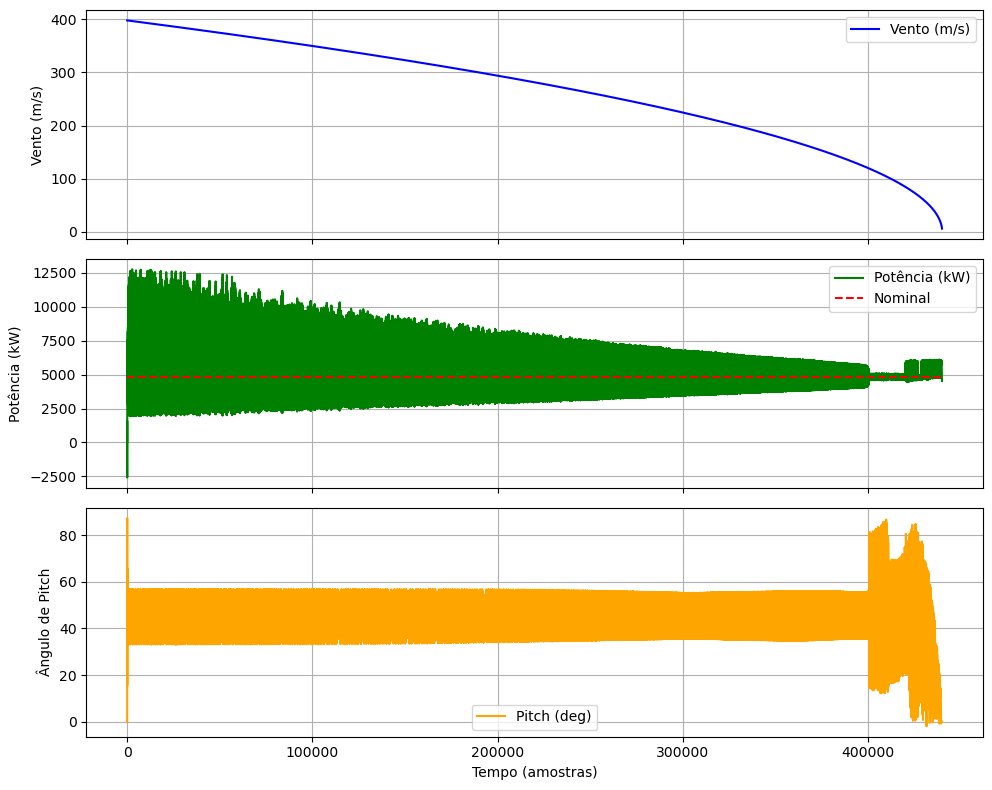

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import control as ct
from numba import njit
import time

# ==========================================
# 1. Funções Compiladas (Numba JIT)
# ==========================================

@njit(fastmath=True)
def get_coeff(lambda_val, phi_val, tsr_axis, pitch_axis, data_table):
    """
    Substitui Cp_calc e Cq_calc.
    Realiza busca rápida na tabela pré-carregada.
    """
    # Encontrar índice mais próximo para TSR (Lambda)
    # Assume que tsr_axis está ordenado
    idx1 = np.argmin(np.abs(tsr_axis - lambda_val))
    
    # Encontrar índice mais próximo para Pitch (Phi)
    idx2 = np.argmin(np.abs(pitch_axis - phi_val))
    
    return data_table[idx1, idx2]

@njit(fastmath=True)
def simulation_core(N_steps, v_wind, 
                    hawt_Ad, hawt_Bd, hawt_X_init,
                    gtc_Ad, gtc_Bd, gtc_Cd, gtc_Dd,
                    pac_Ad, pac_Bd, pac_Cd, pac_Dd,
                    R, RHO, Area, N_g, PI, P_r, 
                    lambda_opt, eta_gc, omega_nom, omega_var,
                    k_p, k_i, Ts,
                    tsr_axis, pitch_axis, cp_table, cq_table):
    
    # --- Pré-alocação de Arrays (Velocidade Extrema) ---
    w_r_hist = np.zeros(N_steps)
    w_g_hist = np.zeros(N_steps)
    theta_s_hist = np.zeros(N_steps)
    tau_r_hist = np.zeros(N_steps)
    tau_g_hist = np.zeros(N_steps)
    phi_m_hist = np.zeros(N_steps)
    P_g_hist = np.zeros(N_steps)
    mode_hist = np.zeros(N_steps) # 1.0 para mode1, 2.0 para mode2
    
    # --- Inicialização de Estados ---
    # HAWT: [wr, wg, theta]
    x_hawt = hawt_X_init.astype(np.float64).copy()
    
    # GTC: [estado]
    x_gtc = np.array([0.0])
    
    # PAC: [estado1, estado2]
    x_pac = np.array([0.0, 0.0])
    
    # Variáveis de Controle
    phi_ref_prev = 0.0
    error_prev = 0.0
    current_mode = 1 # Começa no modo 1
    
    for k in range(N_steps):
        v = v_wind[k]
        
        # Leitura dos estados atuais do HAWT
        w_r = x_hawt[0]
        w_g = x_hawt[1]
        theta_s = x_hawt[2]
        
        # --- 1. Power Controller Logic (PWC) ---
        epsilon = w_g - omega_nom
        
        # Hysteresis simples para troca de modo (exemplo)
        # Se passar da velocidade nominal + tolerância, vai para Mode 2
        if current_mode == 1 and w_g > (omega_nom + 1.0):
            current_mode = 2
        elif current_mode == 2 and w_g < (omega_nom - 1.0):
            current_mode = 1
            phi_ref_prev = 0.0 # Resetar pitch ao voltar para torque control
            
        tau_gr = 0.0
        phi_ref = 0.0
        
        if current_mode == 1:
            # Mode 1: Maximização de Cp (Torque quadrático)
            # u_k assumido 0
            lambda_calc = lambda_opt
            
            # Busca Cp na tabela (Pitch = 0)
            C_p = get_coeff(lambda_calc, 0.0, tsr_axis, pitch_axis, cp_table)
            
            K_opt = RHO * Area * (R**3) * C_p / (2 * (lambda_calc**3) * N_g)
            tau_gr = K_opt * ((w_g / N_g)**2)
            
            phi_ref = 0.0
            phi_ref_prev = 0.0 # Manter rastreio
            error_prev = epsilon # Atualizar erro para transição suave
            
        else: # Mode 2
            # Mode 2: Controle de Potência/Velocidade via Pitch
            # Torque mantém potência constante
            if w_g > 0.1:
                tau_gr = P_r / (eta_gc * w_g)
            else:
                tau_gr = 0.0
                
            # PI Controller para Pitch (Algoritmo de Velocidade/Incremental)
            # phi_ref = phi_prev + kp*e + (ki*Ts - kp)*e_prev
            delta_u = k_p * epsilon + (k_i * Ts - k_p) * error_prev
            phi_ref = phi_ref_prev + delta_u
            
            # Saturação do Pitch (0 a 90 graus)
            if phi_ref < 0: phi_ref = 0
            if phi_ref > 90: phi_ref = 90
            
            # Atualiza memórias do controlador
            phi_ref_prev = phi_ref
            error_prev = epsilon

        # --- 2. Generator Torque Converter (GTC) ---
        u_gtc = np.array([tau_gr])
        # Y = C*x + D*u
        y_gtc = (gtc_Cd @ x_gtc + gtc_Dd @ u_gtc)[0]
        tau_g_applied = y_gtc
        
        P_g = eta_gc * w_g * tau_g_applied
        
        # Atualiza estado GTC: X_new = A*x + B*u
        x_gtc = gtc_Ad @ x_gtc + gtc_Bd @ u_gtc
        
        # --- 3. Pitch Angle Controller (PAC) ---
        u_pac = np.array([phi_ref])
        y_pac = (pac_Cd @ x_pac + pac_Dd @ u_pac)[0]
        phi_m = y_pac
        
        # Atualiza estado PAC
        x_pac = pac_Ad @ x_pac + pac_Bd @ u_pac
        
        # --- 4. Aerodynamic Model (ADM) ---
        if v < 0.1:
            lamb = 0.0
        else:
            lamb = w_r * R / v
            
        C_q = get_coeff(lamb, phi_m, tsr_axis, pitch_axis, cq_table)
        tau_r = RHO * PI * (R**3) * C_q * (v**2) / 2.0
        
        # --- 5. HAWT Dynamics (Plant) ---
        u_hawt = np.array([tau_r, tau_g_applied])
        
        # Atualiza estado HAWT (w_r, w_g, theta)
        x_hawt = hawt_Ad @ x_hawt + hawt_Bd @ u_hawt
        
        # --- Salvar Histórico ---
        w_r_hist[k] = w_r
        w_g_hist[k] = w_g
        theta_s_hist[k] = theta_s
        tau_r_hist[k] = tau_r
        tau_g_hist[k] = tau_g_applied
        phi_m_hist[k] = phi_m
        P_g_hist[k] = P_g
        mode_hist[k] = current_mode

    return w_r_hist, w_g_hist, tau_r_hist, tau_g_hist, phi_m_hist, P_g_hist, mode_hist

# ==========================================
# 2. Preparação de Dados (Python Puro)
# ==========================================

def prepare_simulation():
    # --- Carregar CSVs ---
    print("Carregando tabelas...")
    try:
        # Tente carregar seus arquivos originais
        params_df = pd.read_csv(r'params2.csv')
        params = dict(zip(params_df['Parameter'], params_df['Value']))
        
        df_wind = pd.read_csv(r'Datasets/WindSpeed_V1.csv')
        v = df_wind.iloc[:,0].values + 1
        v = np.sqrt(np.flip(v) )*4*1.5
        
        df_cp = pd.read_csv(r'Cp.csv')
        df_cq = pd.read_csv(r'Cq.csv')
        
        # Preparar Eixos e Tabelas para Numba
        # Assumindo estrutura do seu código original (Coluna 0 = TSR, Resto = Coeficientes por Pitch)
        tsr_axis = df_cp.iloc[:, 0].values.astype(np.float64)
        
        # Ângulos hardcoded do seu script original
        angles = np.array([-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]).astype(np.float64)
        
        # Extrair matrizes de dados (dropando coluna TSR)
        cp_table = df_cp.iloc[:, 1:].values.astype(np.float64)
        cq_table = df_cq.iloc[:, 1:].values.astype(np.float64)
        
    except FileNotFoundError:
        print("AVISO: Arquivos não encontrados. Usando dados fictícios para teste.")
        # Dados Dummy para o código rodar se você copiar e colar agora
        params = {
            'Area': 100, 'B_dt': 1, 'B_r': 1, 'B_g': 1, 'CP_max': 0.45, 'ETA_dt': 0.9, 'ETA_gc': 0.9,
            'J_r': 100, 'J_g': 10, 'K_dt': 1000, 'k_i': 1.0, 'k_p': 0.1, 'LAMBDA_opt': 8, 'N_g': 90,
            'OMEGA_n': 1, 'OMEGA_nom': 100, 'OMEGA_var': 1, 'PHI_opt': 0, 'P_r': 1000, 'PI': np.pi,
            'R': 40, 'RHO': 1.225, 'ALPHA_gc': 10, 'ZETA': 0.7
        }
        v = np.linspace(5, 15, 1000) # Vento rampa
        tsr_axis = np.linspace(0, 20, 100)
        angles = np.linspace(-2, 95, 33)
        cp_table = np.random.rand(100, 33) * 0.4
        cq_table = np.random.rand(100, 33) * 0.05

    Ts = 0.01 # Seu Time Step

    # --- Construção das Matrizes (Control Library) ---
    
    # 1. HAWT Matrices
    B_dt, B_r, B_g = params['B_dt'], params['B_r'], params['B_g']
    J_r, J_g, N_g = params['J_r'], params['J_g'], params['N_g']
    K_dt, ETA_dt = params['K_dt'], params['ETA_dt']
    
    A_hawt = np.array([
        [-(B_dt+B_r)/J_r, B_dt/(N_g*J_r), -K_dt/J_r],
        [(B_dt*ETA_dt)/(N_g*J_g), -(((B_dt*ETA_dt)/(N_g**2))+B_g)*(1/J_g), (K_dt*ETA_dt)/(N_g*J_g)],
        [1, -1/N_g, 0]
    ])
    B_hawt = np.array([
        [1/J_r, 0],
        [0, -1/J_g],
        [0, 0]
    ])
    
    sys_hawt = ct.c2d(ct.ss(A_hawt, B_hawt, np.eye(3), np.zeros((3,2))), Ts, method='zoh')
    
    # 2. GTC Matrices
    alpha_gc = params['ALPHA_gc']
    sys_gtc = ct.c2d(ct.ss(ct.tf([alpha_gc], [1, alpha_gc])), Ts, method='zoh')
    
    # 3. PAC Matrices
    omega_n, zeta = params['OMEGA_n'], params['ZETA']
    sys_pac = ct.c2d(ct.ss(ct.tf([omega_n**2], [1, 2*omega_n*zeta, omega_n**2])), Ts, method='zoh')

    # Retorna tudo compactado para passar ao Numba
    # É crucial usar np.ascontiguousarray para performance máxima no Numba
    matrices = {
        'h_Ad': np.ascontiguousarray(sys_hawt.A), 'h_Bd': np.ascontiguousarray(sys_hawt.B),
        'g_Ad': np.ascontiguousarray(sys_gtc.A), 'g_Bd': np.ascontiguousarray(sys_gtc.B), 'g_Cd': np.ascontiguousarray(sys_gtc.C), 'g_Dd': np.ascontiguousarray(sys_gtc.D),
        'p_Ad': np.ascontiguousarray(sys_pac.A), 'p_Bd': np.ascontiguousarray(sys_pac.B), 'p_Cd': np.ascontiguousarray(sys_pac.C), 'p_Dd': np.ascontiguousarray(sys_pac.D)
    }
    
    return params, v, tsr_axis, angles, cp_table, cq_table, matrices

# ==========================================
# 3. Execução Principal
# ==========================================

if __name__ == "__main__":
    
    # 1. Preparar
    params, v_wind, tsr_axis, pitch_axis, cp_table, cq_table, mats = prepare_simulation()
    
    Ts = 0.01
    N_steps = len(v_wind)
    hawt_X_init = np.array([0.1, 0.1*params['N_g'], 0.0])

    print(f"Iniciando Simulação Numba para {N_steps} passos...")
    
    start_time = time.time()
    
    # 2. Rodar (A primeira execução compila, as próximas são instantâneas)
    results = simulation_core(
        N_steps, v_wind,
        mats['h_Ad'], mats['h_Bd'], hawt_X_init,
        mats['g_Ad'], mats['g_Bd'], mats['g_Cd'], mats['g_Dd'],
        mats['p_Ad'], mats['p_Bd'], mats['p_Cd'], mats['p_Dd'],
        params['R'], params['RHO'], params['Area'], params['N_g'], params['PI'], params['P_r'],
        params['LAMBDA_opt'], params['ETA_gc'], params['OMEGA_nom'], params['OMEGA_var'],
        params['k_p'], params['k_i'], Ts,
        tsr_axis, pitch_axis, cp_table, cq_table
    )
    
    end_time = time.time()
    print(f"Tempo de Execução: {end_time - start_time:.4f} segundos")
    
    # 3. Desempacotar e Plotar
    wr, wg, tr, tg, phim, pg, mode = results

    


    # Exemplo visualização
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    
    ax[0].plot(v_wind, label='Vento (m/s)', color='blue')
    ax[0].set_ylabel('Vento (m/s)')
    ax[0].legend()
    ax[0].grid(True)
    
    ax[1].plot(pg/1000, label='Potência (kW)', color='green')
    ax[1].plot([0, len(pg)], [params['P_r']/1000, params['P_r']/1000], 'r--', label='Nominal')
    ax[1].set_ylabel('Potência (kW)')
    ax[1].legend()
    ax[1].grid(True)
    
    ax[2].plot(phim, label='Pitch (deg)', color='orange')
    ax[2].set_ylabel('Ângulo de Pitch')
    ax[2].set_xlabel('Tempo (amostras)')
    ax[2].legend()
    ax[2].grid(True)
    
    plt.tight_layout()
    plt.show()

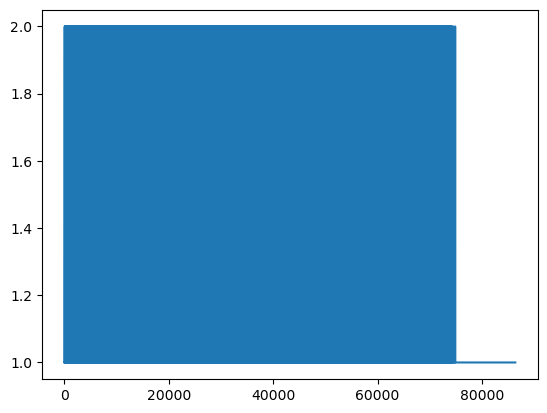

In [31]:
plt.plot(mode[:])

In [37]:
path = r'Datasets\WindSpeedML.csv'
df = pd.read_csv(path)
df.columns = ['time','speed1','speed2','speed3']
df.to_csv('Datasets\WindSpeedML_v1.csv', index=False)

<>:4: SyntaxWarning:

invalid escape sequence '\W'

<>:4: SyntaxWarning:

invalid escape sequence '\W'

C:\Users\claud\AppData\Local\Temp\ipykernel_10504\1460097832.py:4: SyntaxWarning:

invalid escape sequence '\W'



In [42]:
df2 = df.iloc[:,1:2]
df2.to_csv('Datasets\WindSpeedML_v1.csv', index=False)

<>:2: SyntaxWarning:

invalid escape sequence '\W'

<>:2: SyntaxWarning:

invalid escape sequence '\W'

C:\Users\claud\AppData\Local\Temp\ipykernel_10504\3343735545.py:2: SyntaxWarning:

invalid escape sequence '\W'

